# !!!Вся основная информация в ноутбуке с моделью Бэкмана, здесь некоторые расчёты стабильной динамики

## Подготовка данных

In [ ]:
!pip install scanf

In [ ]:
!echo "deb http://downloads.skewed.de/apt bionic main" >> /etc/apt/sources.list
!apt-key adv --keyserver keys.openpgp.org --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool python3-cairo python3-matplotlib

In [ ]:
import pandas as pd
import numpy as np
import data_handler as dh
import model as md
import time
import matplotlib.pyplot as plt
from matplotlib import rc
import pickle

In [ ]:
import importlib
importlib.reload(dh)
importlib.reload(md)

<module 'data_handler' from '/content/data_handler.py'>

In [ ]:
import numba
numba.__version__

'0.51.2'

In [ ]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)
from platform import python_version
print('python', python_version())
print('numpy', np.__version__)
print('pandas', pd.__version__)
import graph_tool
print('graph_tool', graph_tool.__version__)

/usr/bin/python3
3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
sys.version_info(major=3, minor=7, micro=12, releaselevel='final', serial=0)
python 3.7.12
numpy 1.19.5
pandas 1.1.5
graph_tool 2.43 (commit 9d41331e, Wed Jul 7 15:32:52 2021 +0200)


# Модель стабильной динамики

parameter $\mu = 0$

In [ ]:
sd_save = 'stable_dynamics_results/'
#net_name = 'Anaheim_net.tntp'
#trips_name = 'Anaheim_trips.tntp'
net_name = 'graph.tntp'
trips_name = 'trips.tntp'

In [ ]:
handler = dh.DataHandler()
graph_correspondences, total_od_flow = handler.GetGraphCorrespondences(trips_name)
graph_data = handler.GetGraphData(net_name, columns = ['init_node', 'term_node', 'capacity', 'free_flow_time'])
init_capacities = np.copy(graph_data['graph_table']['capacity'])

## Парадокс браеса
В качестве примера для моделирования социального оптимума в модели стабильной динамики была взята схема, демонстрирующая парадокс Браеса

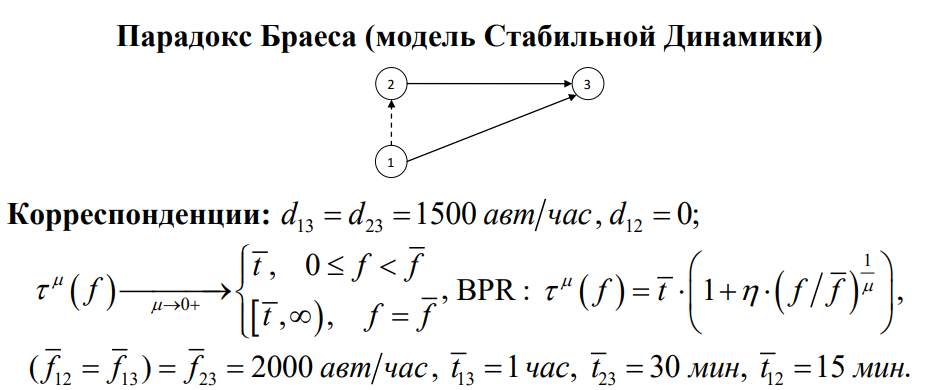

### и её запись в графе

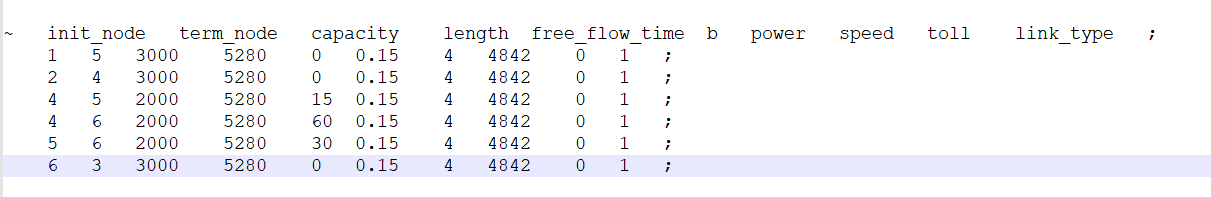

## Base flows
Для начала надо получить допустимое распределение потоков

In [ ]:
alpha = 0.75
graph_data['graph_table']['capacity'] = init_capacities * alpha
model = Model(graph_data, graph_correspondences,
                 total_od_flow, mu = 0)

graph_data['graph_table'].head()

,init_node,init_node_thru,term_node,term_node_thru,capacity,free_flow_time
0,1,False,5,True,2250.0,0.0
1,2,False,4,True,2250.0,0.0
2,4,True,5,True,1500.0,15.0
3,4,True,6,True,1500.0,60.0
4,5,True,6,True,1500.0,30.0


In [ ]:
assert(model.mu == 0)
max_iter = 1000

solver_kwargs = {'eps': 1e-4,
                 'max_iter': max_iter, 'stop_crit': 'max_iter',
                 'verbose': True, 'verbose_step': 200, 'save_history': True}
tic = time.time()
result = model.find_equilibrium(solver_name = 'ustm', composite = True,
                                solver_kwargs = solver_kwargs,
                                base_flows = alpha * graph_data['graph_table']['capacity'])
                                #base_flows here doesnt define anything now
toc = time.time()
print('Elapsed time: {:.0f} sec'.format(toc - tic))

#---------------------------------------------
#Поменял тут:
time_ratio_calc = result['times'] / graph_data['graph_table']['free_flow_time']
time_ratio = [0. if graph_data['graph_table']['free_flow_time'][i] == 0 else time_ratio_calc[i]  for i in range(len(time_ratio_calc))]

print('Time ratio =', np.max(time_ratio))
#---------------------------------------------

print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['capacity']) - 1, end = '\n\n')

result['elapsed_time'] = toc - tic

base_flows = result['flows']

In [ ]:
print(result['flows'])
print(result['times'])
print(result['zone travel times'])

[1.5000000e+003 1.5000000e+003 2.8556406e-144 1.5000000e+003
 1.5000000e+003 3.0000000e+003]
[0.00000000e+000 0.00000000e+000 1.50000000e+001 4.91854963e+136
 4.91854963e+136 2.88381440e+155]
{(1, 3): 2.883814404839662e+155, (2, 3): 2.883814404839662e+155}


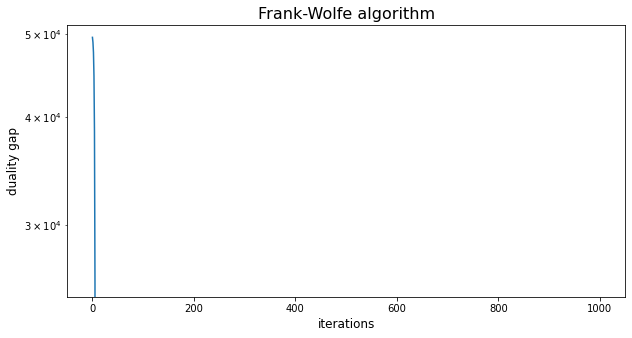

In [ ]:
dual_gaps = np.array(result['history']['dual_gap'])
iters = np.array(result['history']['iter'])
plt.figure(figsize = (10, 5))
plt.plot(iters[:], dual_gaps[:])
plt.title('Frank-Wolfe algorithm', fontsize = 16)
plt.ylabel('duality gap', fontsize = 12)
plt.xlabel('iterations', fontsize = 12)
plt.yscale('log')
plt.show()

In [ ]:
#with open(sd_save + 'anaheim_' + 'ustm' + '_base_flows_max_iter_' + str(max_iter) + '_SD.pickle', 'wb') as f:
#    pickle.dump(base_flows, f)

## Модель
С этого момента, посчитав допустимые потоки, возвращаем модели начальные пропускные способности и пробуем её на разных численных методах

In [ ]:
# with open('graph_' + 'ustm' + '_base_flows_max_iter_' + str(1000) + '_SD.pickle', 'rb') as f:
#     base_flows = pickle.load(f)

In [ ]:
epsilons = np.logspace(2,0,9)
epsilons

array([100.        ,  56.23413252,  31.6227766 ,  17.7827941 ,
        10.        ,   5.62341325,   3.16227766,   1.77827941,
         1.        ])

In [ ]:
graph_data['graph_table']['capacity'] = init_capacities
model = Model(graph_data, graph_correspondences,
                 total_od_flow, mu = 0  )

graph_data['graph_table'].head()

,init_node,init_node_thru,term_node,term_node_thru,capacity,free_flow_time
0,1,False,5,True,3000.0,0.0
1,2,False,4,True,3000.0,0.0
2,4,True,5,True,2000.0,15.0
3,4,True,6,True,2000.0,60.0
4,5,True,6,True,2000.0,30.0


## Universal Similar Triangles

In [ ]:
assert(model.mu == 0)
max_iter = 40000
for index, eps_abs in enumerate(epsilons):
    print('eps_abs =', eps_abs)
    solver_kwargs = {'eps_abs': eps_abs,
                     'max_iter': max_iter, 'stop_crit': 'dual_gap',
                     'verbose': True, 'verbose_step': 2000, 'save_history': True}
    tic = time.time()
    result = model.find_equilibrium(solver_name = 'ustm', composite = True,
                                    solver_kwargs = solver_kwargs, base_flows = base_flows)
    toc = time.time()
    print('Elapsed time: {:.0f} sec'.format(toc - tic))
    time_ratio_calc = result['times'] / graph_data['graph_table']['free_flow_time']
    time_ratio = [0. if graph_data['graph_table']['free_flow_time'][i] == 0 else time_ratio_calc[i]  for i in range(len(time_ratio_calc))]

    print('Time ratio =', np.max(time_ratio))
    print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['capacity']) - 1, end = '\n\n')

    result['eps_abs'] = eps_abs
    print(result['flows'])
    result['elapsed_time'] = toc - tic
    #with open(sd_save + 'anaheim_result_' + 'ustm' + '_eps_abs_' + str(index) + '_SD.pickle', 'wb') as f:
    #    pickle.dump(result, f)

In [ ]:
#index += 9
#epsilons = [300, 200]

In [ ]:
print(result['flows'])
print(result['times'])
print(result['zone travel times'])

In [ ]:
base_flows_new = base_flows

In [ ]:
dual_gaps = np.array(result['history']['dual_gap'])
iters = np.array(result['history']['iter'])
plt.figure(figsize = (10, 5))
plt.plot(iters[1000:], dual_gaps[1000:])
plt.title('Universal Similar Triangles', fontsize = 16)
plt.ylabel('duality gap', fontsize = 12)
plt.xlabel('iterations', fontsize = 12)
plt.yscale('log')
plt.show()

## Universal Gradient Descent

In [ ]:
#weighted t added
assert(model.mu == 0)
max_iter = 40000
for index, eps_abs in enumerate(epsilons):
    print('eps_abs =', eps_abs)
    solver_kwargs = {'eps_abs': eps_abs,
                     'max_iter': max_iter, 'stop_crit': 'dual_gap',
                     'verbose': True, 'verbose_step': 2000, 'save_history': True}
    tic = time.time()
    result = model.find_equilibrium(solver_name = 'ugd', composite = True,
                                    solver_kwargs = solver_kwargs, base_flows = base_flows)
    toc = time.time()
    print('Elapsed time: {:.0f} sec'.format(toc - tic))
    time_ratio_calc = result['times'] / graph_data['graph_table']['free_flow_time']
    time_ratio = [0. if graph_data['graph_table']['free_flow_time'][i] == 0 else time_ratio_calc[i]  for i in range(len(time_ratio_calc))]

    print('Time ratio =', np.max(time_ratio))
    print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['capacity']) - 1, end = '\n\n')
    print(result['flows'])
    result['eps_abs'] = eps_abs
    result['elapsed_time'] = toc - tic
    #with open(sd_save + 'anaheim_result_' + 'ugd' + '_eps_abs_' + str(index) + '_SD.pickle', 'wb') as f:
    #    pickle.dump(result, f)

eps_abs = 100.0
Composite optimization...
Oracles created...
Universal gradient descent method...
Primal_init = 112500
Dual_init = -15000
Duality_gap_init = 120000

Iterations number: 2000
Inner iterations number: 4000
Primal_func_value = 126498
Dual_func_value = -40042.7
Duality_gap = 94957.3
Duality_gap / Duality_gap_init = 0.791311

Iterations number: 4000
Inner iterations number: 8000
Primal_func_value = 126974
Dual_func_value = -40253.5
Duality_gap = 94746.5
Duality_gap / Duality_gap_init = 0.789554

Iterations number: 6000
Inner iterations number: 12000
Primal_func_value = 127144
Dual_func_value = -40328.5
Duality_gap = 94671.5
Duality_gap / Duality_gap_init = 0.788929

Iterations number: 8000
Inner iterations number: 16000
Primal_func_value = 127231
Dual_func_value = -40366.9
Duality_gap = 94633.1
Duality_gap / Duality_gap_init = 0.788609

Iterations number: 10000
Inner iterations number: 20000
Primal_func_value = 127283
Dual_func_value = -40390.2
Duality_gap = 94609.8
Duality_g

In [ ]:
print(result['flows'])
print(result['times'])
print(result['zone travel times'])

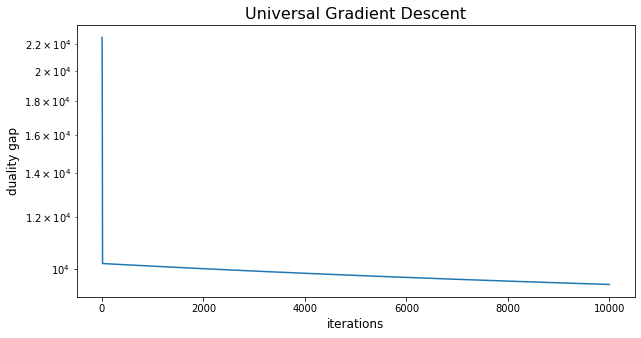

In [ ]:
dual_gaps = np.array(result['history']['dual_gap'])
iters = np.array(result['history']['iter'])
plt.figure(figsize = (10, 5))
plt.plot(iters[:], dual_gaps[:])
plt.title('Universal Gradient Descent', fontsize = 16)
plt.ylabel('duality gap', fontsize = 12)
plt.xlabel('iterations', fontsize = 12)
plt.yscale('log')
plt.show()

In [ ]:
#index += 9
#epsilons = [300, 200]

## Weighted Dual Averages

### Composite optimization

In [ ]:
assert(model.mu == 0)
max_iter = 50000
solver_kwargs = {'max_iter': max_iter, 'stop_crit': 'max_iter',
                 'verbose': True, 'verbose_step': 4000, 'save_history': True}
tic = time.time()
result = model.find_equilibrium(solver_name = 'wda', composite = True, 
                                solver_kwargs = solver_kwargs, base_flows = base_flows)
toc = time.time()
print('Elapsed time: {:.0f} sec'.format(toc - tic))
print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['free_flow_time']))
print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['capacity']) - 1, end = '\n\n')

result['elapsed_time'] = toc - tic
with open(sd_save + 'anaheim_result_' + 'wda' + '_max_iter_' + str(max_iter) + '_SD.pickle', 'wb') as f:
    pickle.dump(result, f)

Composite optimization...
Oracles created...
Weighted dual averages method...
Primal_init = 1.24813e+06
Dual_init = -1.24813e+06
Duality_gap_init = 290.05

Iterations number: 4000
Primal_func_value = 1.2482e+06
Dual_func_value = -1.24822e+06
Duality_gap = 20.728
Duality_gap / Duality_gap_init = 0.0714635

Iterations number: 8000
Primal_func_value = 1.2482e+06
Dual_func_value = -1.24822e+06
Duality_gap = 14.3112
Duality_gap / Duality_gap_init = 0.0493405

Iterations number: 12000
Primal_func_value = 1.24821e+06
Dual_func_value = -1.24822e+06
Duality_gap = 11.5552
Duality_gap / Duality_gap_init = 0.0398387

Iterations number: 16000
Primal_func_value = 1.24821e+06
Dual_func_value = -1.24822e+06
Duality_gap = 9.94551
Duality_gap / Duality_gap_init = 0.0342889

Iterations number: 20000
Primal_func_value = 1.24821e+06
Dual_func_value = -1.24822e+06
Duality_gap = 8.85476
Duality_gap / Duality_gap_init = 0.0305284

Iterations number: 24000
Primal_func_value = 1.24821e+06
Dual_func_value = -1.2

### Non-composite optimization

In [ ]:
assert(model.mu == 0)
max_iter = 50000
solver_kwargs = {'max_iter': max_iter, 'stop_crit': 'max_iter',
                 'verbose': True, 'verbose_step': 4000, 'save_history': True}
tic = time.time()
result = model.find_equilibrium(solver_name = 'wda', composite = False, 
                                solver_kwargs = solver_kwargs, base_flows = base_flows)
toc = time.time()
print('Elapsed time: {:.0f} sec'.format(toc - tic))
print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['free_flow_time']))
print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['capacity']) - 1, end = '\n\n')

result['elapsed_time'] = toc - tic
with open(sd_save + 'anaheim_result_' + 'wda_noncomposite' + '_max_iter_' + str(max_iter) + '_SD.pickle', 'wb') as f:
    pickle.dump(result, f)

Non-composite optimization...
Oracles created...
Weighted dual averages method...
Primal_init = 1.24813e+06
Dual_init = -1.24813e+06
Duality_gap_init = 290.05

Iterations number: 4000
Primal_func_value = 1.24816e+06
Dual_func_value = -1.24819e+06
Duality_gap = 84.9128
Duality_gap / Duality_gap_init = 0.292752

Iterations number: 8000
Primal_func_value = 1.24816e+06
Dual_func_value = -1.2482e+06
Duality_gap = 70.9427
Duality_gap / Duality_gap_init = 0.244588

Iterations number: 12000
Primal_func_value = 1.24817e+06
Dual_func_value = -1.24821e+06
Duality_gap = 55.6904
Duality_gap / Duality_gap_init = 0.192003

Iterations number: 16000
Primal_func_value = 1.24818e+06
Dual_func_value = -1.24821e+06
Duality_gap = 47.0835
Duality_gap / Duality_gap_init = 0.162329

Iterations number: 20000
Primal_func_value = 1.24818e+06
Dual_func_value = -1.24821e+06
Duality_gap = 41.4179
Duality_gap / Duality_gap_init = 0.142796

Iterations number: 24000
Primal_func_value = 1.24818e+06
Dual_func_value = -1.

## Plots

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
import numpy as np
sd_save = 'stable_dynamics_results/'

In [ ]:
"""
for method in ['ustm', 'ugd']:
    results = []
    i = 0
    while True:
        try:
            with open(sd_save + 'anaheim_result_' + method + '_eps_abs_'
                      + str(i) + '_SD.pickle', 'rb') as f:
                result = pickle.load(f)
                results.append(result) 
        except FileNotFoundError:
            break
        i += 1
    results.sort(key = lambda res : res['eps_abs'])
    
    for i, result in enumerate(results):
        with open(sd_save + 'anaheim_result_' + method + '_eps_abs_' 
                  + str(i) + '_SD.pickle', 'wb') as f:
            pickle.dump(result, f)
"""

In [ ]:
results = {}

for method in ['ustm', 'ugd']:
    results[method] = {}
    results[method]['iters'] = []
    results[method]['inner_iters'] = []
    results[method]['epsilon'] = []
    results[method]['dual_gap_init'] = []
    i = 0
    while True:
        try:
            with open(sd_save + 'anaheim_result_' + method + '_eps_abs_'
                      + str(i) + '_SD.pickle', 'rb') as f:
                result = pickle.load(f)
                results[method]['epsilon'].append(result['eps_abs'])
                results[method]['iters'].append(result['iter_num'])
                results[method]['inner_iters'].append(result['history'].get('inner_iters')[-1])
                results[method]['dual_gap_init'].append(result['history'].get('dual_gap')[0])
        except FileNotFoundError:
            break
        i += 1

In [ ]:
for method in ['wda', 'wda_noncomposite']:
    results[method] = {}
    with open(sd_save + 'anaheim_result_' + method + '_max_iter_50000_SD.pickle', 'rb') as f:
        result = pickle.load(f)
        results[method]['epsilon'] = result['history'].get('dual_gap')
        results[method]['iters'] = result['history'].get('iter')
        results[method]['dual_gap_init'] = result['history'].get('dual_gap')[0]

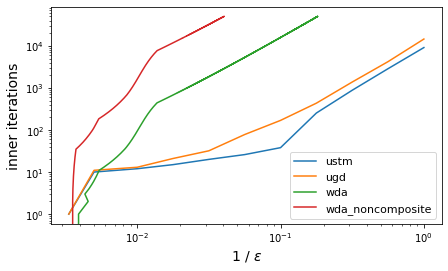

In [ ]:
plt.figure(figsize=(7,4))
#plt.title('Convergence for Stable Dynamics model', fontsize=20)
for method, data in results.items():
    x = 1. / np.array(data['epsilon'])
    if 'inner_iters' in data:
        y = np.array(data['inner_iters'])
    else:
        y = np.array(data['iters'])
    plt.plot(x, y, label = method)
plt.legend(prop = {'size' : 11})
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'1 / $\varepsilon$', fontsize = 14)
plt.ylabel('inner iterations', fontsize = 14)
#plt.savefig('SD_convergence_1.jpg', dpi = 300)
plt.show()

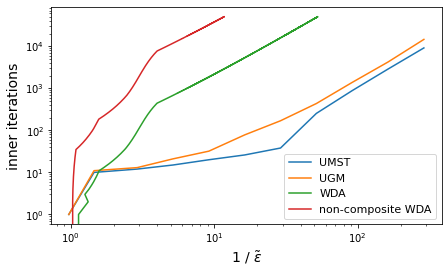

In [ ]:
#inner iterations vs relative accuracy = eps_abs / dual_gap_init
plt.figure(figsize=(7,4))

method_names = {'ustm' : 'UMST', 'ugd' : 'UGM', 'wda' : 'WDA',
                'wda_noncomposite' : 'non-composite WDA'}
for method, data in results.items():
    x = 1. / (np.array(data['epsilon']) / np.array(data['dual_gap_init']))
    if 'inner_iters' in data:
        y = np.array(data['inner_iters'])
    else:
        y = np.array(data['iters'])
    plt.plot(x, y, label = method_names[method])
plt.legend(prop = {'size' : 11})
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'1 / $\tilde\varepsilon$', fontsize = 14)
plt.ylabel('inner iterations', fontsize = 14)
#plt.savefig('sd_convergence_rel_eps.jpg', dpi = 300)
plt.show()